In [ ]:
!pip install pycountry_convert

In [ ]:
import pandas as pd
import pycountry_convert as pc

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lecture des données

In [ ]:
financement_df = pd.read_csv("financement.csv", sep=",", index_col=0) # Lecture du fichier csv

# Analyse

In [ ]:
print("Columns :", financement_df.columns)

Columns : Index(['ID', 'nom', 'categorie', 'categorie_principale', 'monaie',
       'date_butoire', 'objectif', 'lancement', 'promesse', 'etat',
       'supporters', 'pays', 'promesse_usd1', 'promesse_usd2', 'objectif_usd'],
      dtype='object')


In [ ]:
financement_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    378661 non-null  int64  
 1   nom                   378657 non-null  object 
 2   categorie             378661 non-null  object 
 3   categorie_principale  378661 non-null  object 
 4   monaie                378661 non-null  object 
 5   date_butoire          378661 non-null  object 
 6   objectif              378661 non-null  float64
 7   lancement             378661 non-null  object 
 8   promesse              378661 non-null  float64
 9   etat                  378661 non-null  object 
 10  supporters            378661 non-null  int64  
 11  pays                  378661 non-null  object 
 12  promesse_usd1         374864 non-null  float64
 13  promesse_usd2         378661 non-null  float64
 14  objectif_usd          378661 non-null  float64
dtype

In [ ]:
pd.DataFrame({'total_missing': financement_df.isnull().sum(), 'perc_missing': (financement_df.isnull().sum()/len(financement_df))*100})

,total_missing,perc_missing
ID,0,0.000000
nom,4,0.001056
categorie,0,0.000000
categorie_principale,0,0.000000
monaie,0,0.000000
date_butoire,0,0.000000
objectif,0,0.000000
lancement,0,0.000000
promesse,0,0.000000
etat,0,0.000000


On remarque que nous avons quelques valeurs manquantes dans notre dataframe. 4 pour le champs "nom" et 3797 pour le champs "promesse_usd1". Le taux de données manquantes étant faible, nous décidons de supprimer les lignes.

In [ ]:
financement_df.dropna(inplace=True)

### Analyse de la variable à prédire

Analysons la variable que nous souhaitons prédire (etat)

In [ ]:
financement_df["etat"].unique()

array(['failed', 'canceled', 'successful', 'live', 'suspended'],
      dtype=object)

In [ ]:
financement_df["etat"].value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: etat, dtype: int64

On ne rend pas vraiment compte de la proportion dans le dataset final. Regardons plûtot la proportion.

In [ ]:
financement_df["etat"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

failed        52.7%
successful    35.7%
canceled      10.3%
live           0.7%
suspended      0.5%
Name: etat, dtype: object

On remarque que les deux modalités : live, suspended ne représentent que 1.3% de l'ensemble de nos enregistrements (respectivement 0.7% et 0.5%). On décide donc de suppimer les lignes avec ces deux modalités vu qu'elles ne représentent qu'une partie de notre échantillon. 

In [ ]:
financement_df = financement_df[~financement_df["etat"].isin(["undefined", "live", "suspended"])]

On remarque aussi que la colonne que nous souhaitons prédire est du String. Mappons là en integer. On décide de regrouper failed et canceled pour faire de la classification binaire

In [ ]:
financement_df["etat_int"] = financement_df["etat"].map({'failed': 0, 'canceled': 0, 'successful': 1})

Regardons s'il y a des variables corrélées entre elles dans notre ensemble de données. La corrélation entre variables peut poser des problèmes lors de l'entraînement de modèles de machine learning, car cela peut entraîner une instabilité des coefficients des modèles et une baisse de leur précision.

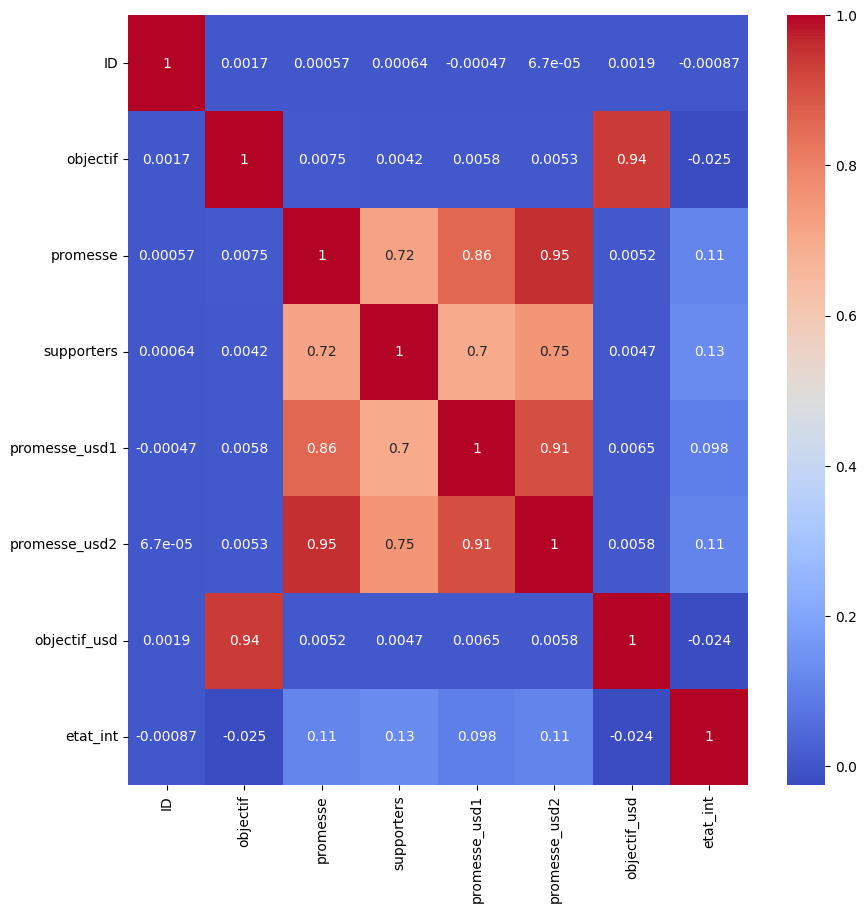

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(financement_df.corr(), annot=True, cmap="coolwarm", ax=ax)
plt.show()

Nous pouvons remarquer que nous avons des variables corréler entre-elles. Par exemples, objectif avec objectif_usd ainsi que promesse avec promesse_usd_1 et promesse_usd_2. Supprimons les colonnes qui contiennent des montants dans des devises différentes et gardons uniquement les colonnes en USD. Ainsi, nous aurons des montants exprimés dans la même monnaie, ce qui évitera que les valeurs de ces colonnes faussent notre analyse.

Afin de s'assurer que les montants sont exprimés dans la même monnaie et d'éviter les écarts de conversion, nous avons décidé de garder les colonnes 'objectif_usd' et 'promesse_usd2'. Ces deux colonnes ont été converties par la même plateforme de conversion (fixer.io), ce qui garantit leur homogénéité en termes de devise.

In [ ]:
financement_df.drop(["objectif", "promesse", "promesse_usd1"], axis=1, inplace=True)

## Analyse des variables numériques

In [ ]:
describe_df = financement_df.describe().apply(lambda x: x.apply('{0:.2f}'.format))
describe_df

,ID,supporters,promesse_usd2,objectif_usd,etat_int
count,370219.00,370219.00,370219.00,370219.00,370219.00
mean,1074476926.20,106.99,9144.48,45091.69,0.36
std,619206866.95,915.27,91581.26,1128616.59,0.48
min,5971.00,0.00,0.00,0.01,0.00
25%,537570578.50,2.00,32.44,2000.00,0.00
50%,1075162847.00,12.00,632.47,5500.00,0.00
75%,1610098310.50,57.00,4076.00,15984.95,1.00
max,2147476221.00,219382.00,20338986.27,166361390.71,1.00


On remarque que pour chaque variable, la moyenne est supérieur au 3 quartile, ce qui signifie qu'il y a des valeurs (élevées) extrèmes.
Essayons, de représenter ça avec des boites à moustache

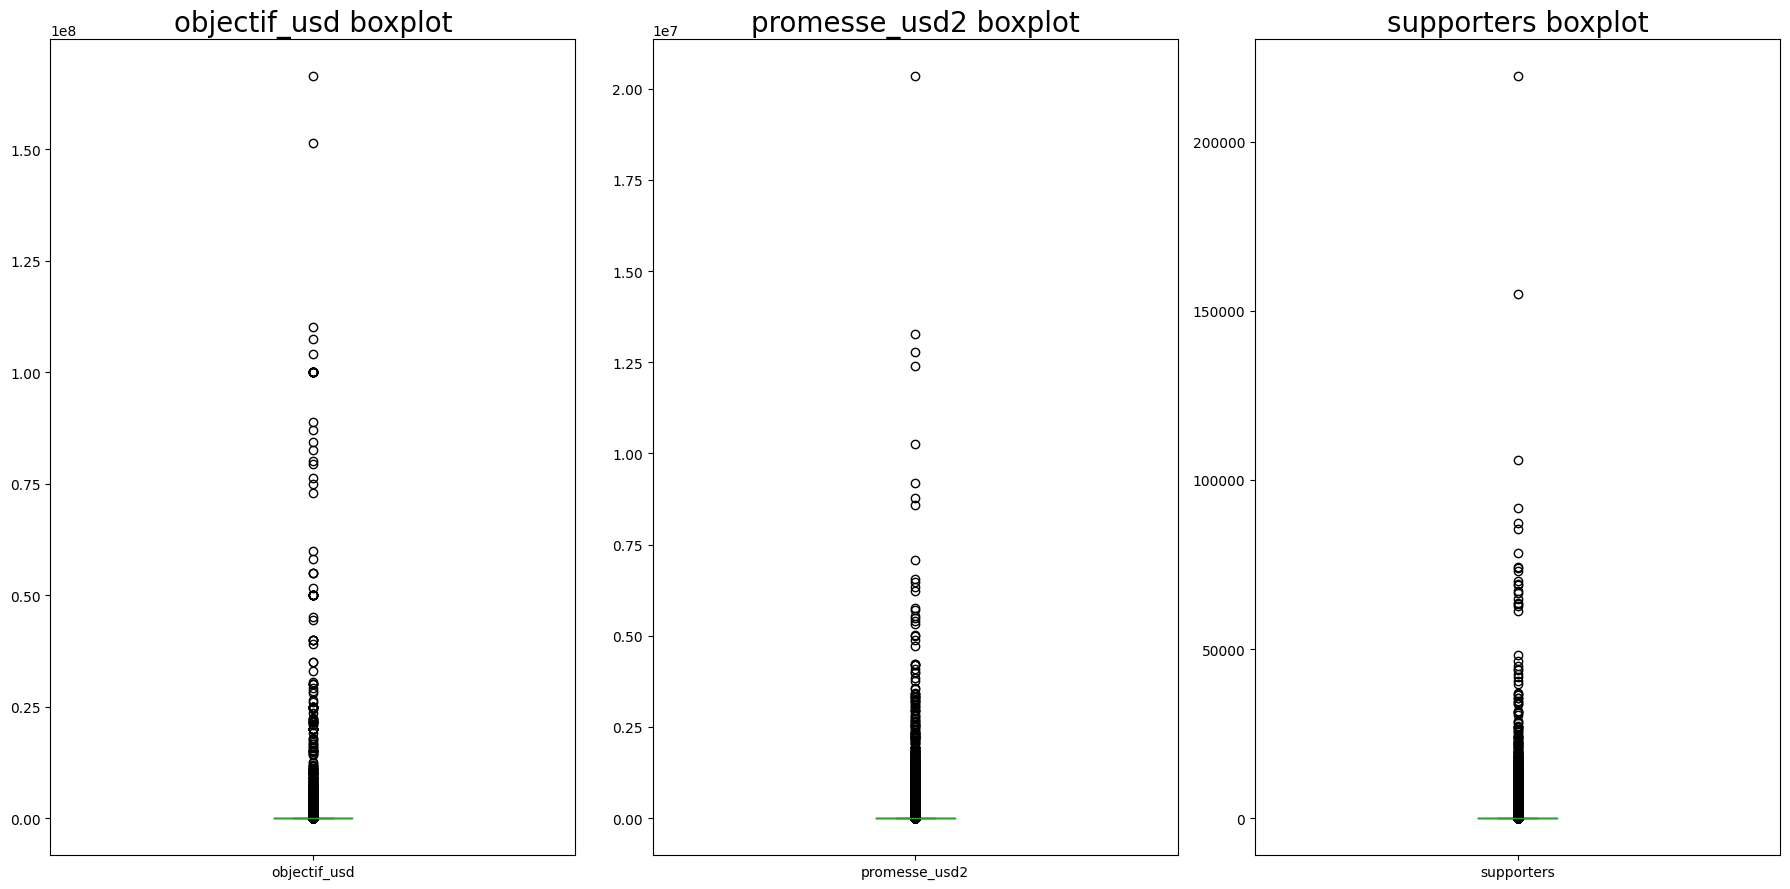

In [ ]:
num_col = ['objectif_usd', 'promesse_usd2', 'supporters']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,9))

for i, ax in enumerate(axes.flat):
    financement_df[num_col[i]].plot.box(ax=ax)
    ax.set_title(f"{num_col[i]} boxplot", fontsize=20)

plt.tight_layout()
plt.show()

On remarque clairement qu'il y a de nombreuses valeurs extrèmes. Elles semblent être des données légitimes. Pour que notre modèle soit le plus performant possible, il semble intéressant de créer des categories.

In [ ]:
for col in num_col:
  col_stats = financement_df[col].describe()
  bins = [
      col_stats.get("min"), 
      col_stats.get("25%"), 
      col_stats.get("50%"), 
      col_stats.get("75%"), 
      col_stats.get("max"), 
  ]

  labels = ['Très faible', 'Faible', 'Moyen', 'Elevé']
  financement_df[f'{col}_cat'] = pd.cut(financement_df[col], bins=bins, labels=labels)

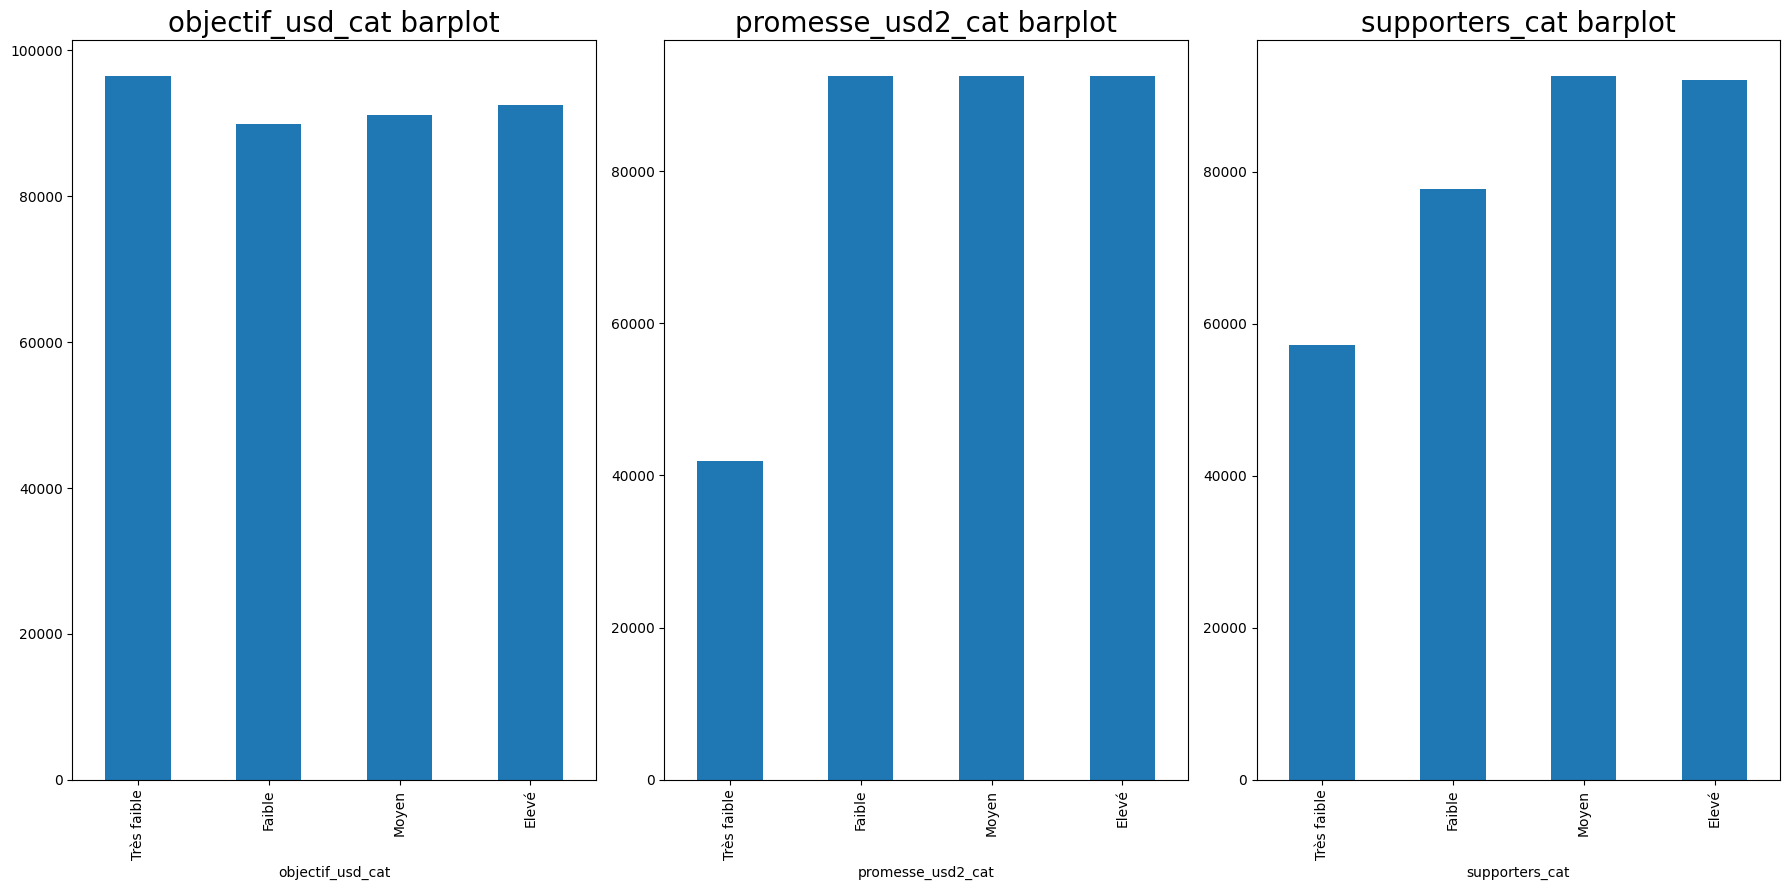

In [ ]:
cat_col = [col for col in financement_df.columns if col.endswith("_cat")]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,9))

for i, ax in enumerate(axes.flat):
    financement_df.groupby(f'{cat_col[i]}')[cat_col[i].split("_cat")[0]].count().plot.bar(ax=ax)
    ax.set_title(f"{cat_col[i]} barplot", fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[cat_col])], axis=1)

Nous pouvons remarquer que les catégories que nous avons créées sont beaucoup plus corrélées à la variable 'etat_int' que les variables d'origine. Nous constatons également que ce sont les catégories extrêmes ('Elevé' et 'Faible') qui ont les taux de corrélation les plus élevés.

# Analyse des variables non numériques

Commençons par lister les variables non numériques

In [ ]:
list(financement_df.select_dtypes(exclude=['uint8', 'int', 'float', 'category']).columns)

['nom',
 'categorie',
 'categorie_principale',
 'monaie',
 'date_butoire',
 'lancement',
 'etat',
 'pays']

Tout d'abord, analysons si certains mots reviennent plus fréquemment dans les noms des projets financés ou non financés.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


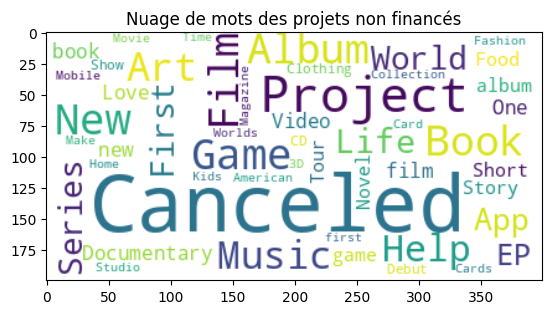

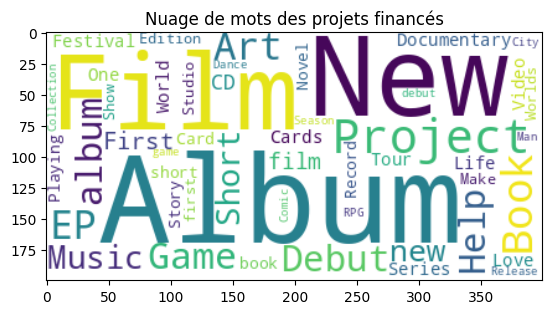

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = stopwords.words('english')

translator = str.maketrans('', '', string.punctuation)

def remove_stopwords(text):

    text = str(text).translate(translator)

    filtered_text = [word for word in text.split() if word.lower() not in stop_words]
    filtered_text = [word for word in filtered_text if not word.isdigit()]

    return " ".join(filtered_text)

financement_df['nom'] = financement_df['nom'].apply(remove_stopwords)

cloud_generator = WordCloud(background_color='white', random_state=1)

wordcloud_image = cloud_generator.fit_words(financement_df[financement_df["etat_int"] == 0]["nom"].str.split(expand=True).stack().value_counts().head(50))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title("Nuage de mots des projets non financés")
plt.show()

wordcloud_image = cloud_generator.fit_words(financement_df[financement_df["etat_int"] == 1]["nom"].str.split(expand=True).stack().value_counts().head(50))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title("Nuage de mots des projets financés")
plt.show()

In [ ]:
print("Mots les plus fréquent dans les projets non financés :")
display(financement_df[financement_df["etat_int"] == 0]["nom"].str.split(expand=True).stack().value_counts().head(10))

print("\nMots les plus fréquent dans les projets non financés :")
display(financement_df[financement_df["etat_int"] == 1]["nom"].str.split(expand=True).stack().value_counts().head(10))

Mots les plus fréquent dans les projets non financés :


Canceled    23125
Project      5983
New          4270
Game         4246
Book         3904
Film         3808
Album        3796
Art          3676
Music        3358
Help         3090
dtype: int64


Mots les plus fréquent dans les projets non financés :


Album      5234
New        4353
Film       3862
Project    3627
Book       2855
EP         2589
Art        2435
Game       2344
Help       2178
album      2121
dtype: int64

Nous pouvons remarquer que les mots qui reviennent le plus fréquemment sont souvent les mêmes, que le projet soit financé ou non financé...

Penchons nous maintenant sur les categories du projet

In [ ]:
# Calcule le nombre de projets financés et non financés pour chaque catégorie
count_by_category_state = financement_df.groupby(["categorie", "etat_int"])["ID"].count().reset_index()
count_by_category_state.columns = ["categorie", "etat_int", "nb"]

# Calcule la proportion de projets financés pour chaque catégorie
total_by_category = count_by_category_state.groupby("categorie")["nb"].transform("sum")
count_by_category_state["proportion"] = count_by_category_state["nb"] / total_by_category

# Transpose la table pivotée
proportions_by_category = count_by_category_state.pivot(index="categorie", columns="etat_int", values="proportion").reset_index()
proportions_by_category.columns = ["categorie", "non_finance", "finance"]

<Axes: title={'center': "Proportion de l'etat du projet (financé ou non) par categorie"}, xlabel='categorie'>

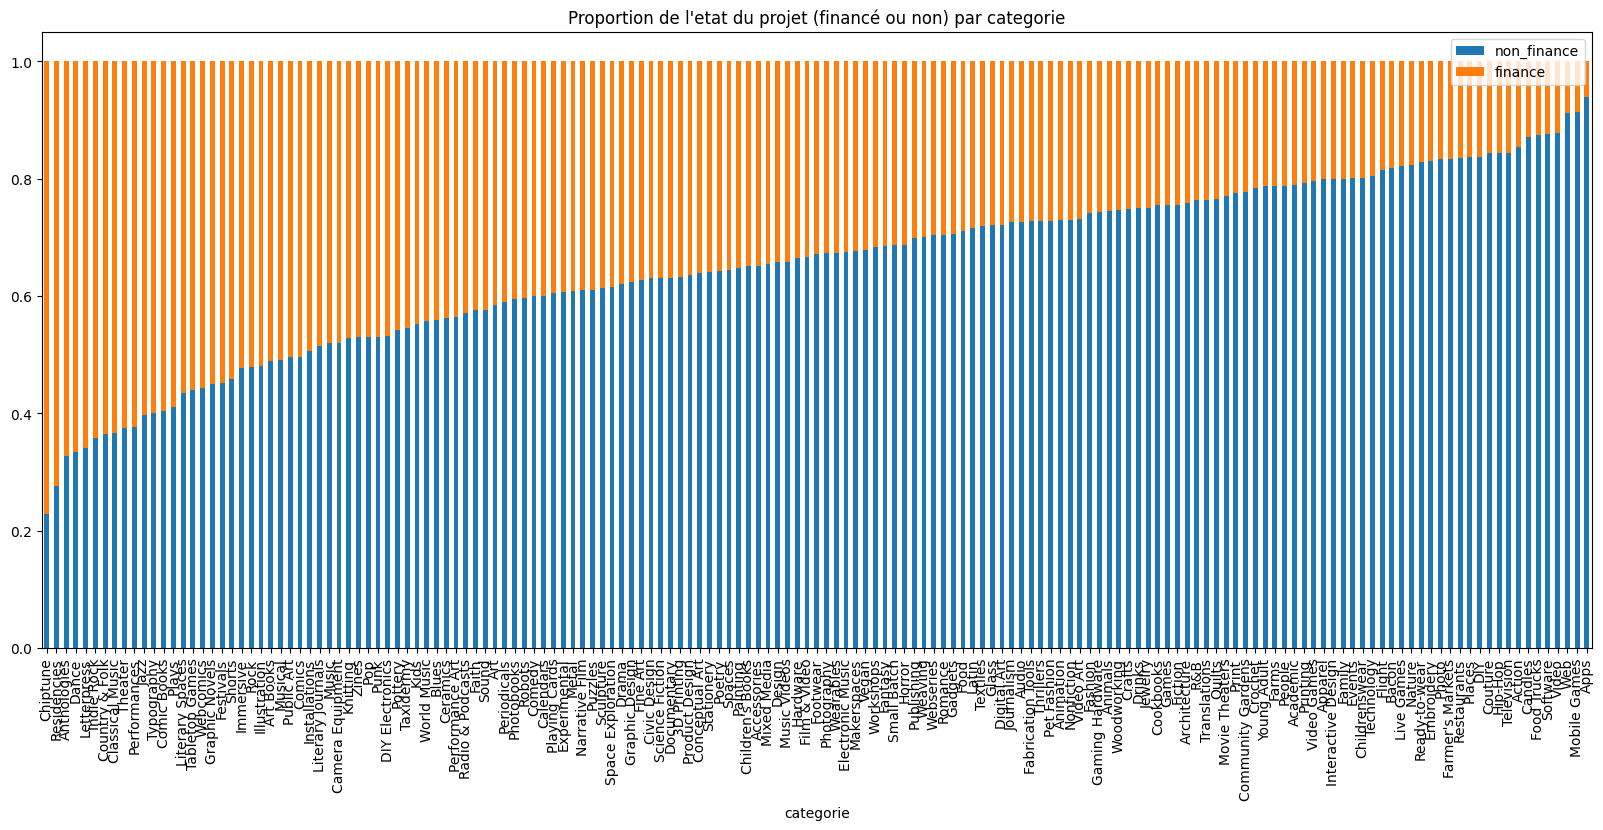

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
proportions_by_category.sort_values(by='finance', ascending=False).plot(
  x = 'categorie',
  kind = 'bar',
  stacked = True,
  title = "Proportion de l'etat du projet (financé ou non) par categorie",
  mark_right = True, 
  ax=ax
)

Il est évident que certaines catégories ont une plus grande probabilité d'être financées que d'autres. Par exemple, près de 80% des projets Chiptune ont été financés, tandis que seulement 10% des projets Apps ont été financés.

Vérifions notre observations avec la vartiable categorie_principale

In [ ]:
# Calcule le nombre de projets financés et non financés pour chaque catégorie
count_by_main_category_state = financement_df.groupby(["categorie_principale", "etat_int"])["ID"].count().reset_index()
count_by_main_category_state.columns = ["categorie_principale", "etat_int", "nb"]

# Calcule la proportion de projets financés pour chaque catégorie
total_by_main_category = count_by_main_category_state.groupby("categorie_principale")["nb"].transform("sum")
count_by_main_category_state["proportion"] = count_by_main_category_state["nb"] / total_by_main_category

# Transpose la table pivotée
proportions_by_main_category = count_by_main_category_state.pivot(index="categorie_principale", columns="etat_int", values="proportion").reset_index()
proportions_by_main_category.columns = ["categorie_principale", "non_finance", "finance"]

<Axes: title={'center': "Proportion de l'etat du projet (financé ou non) par categorie_principale"}, xlabel='categorie_principale'>

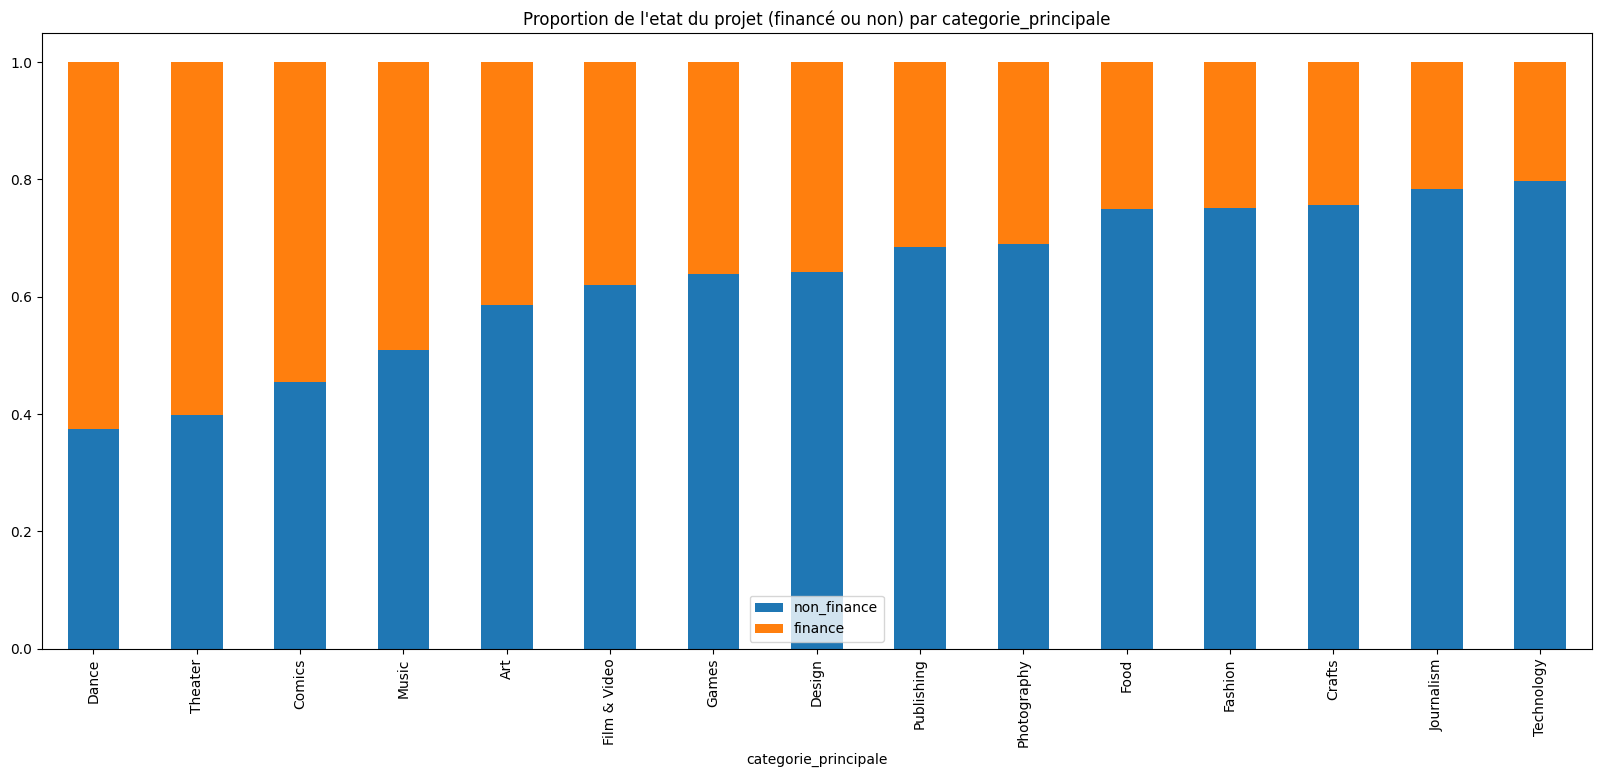

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
proportions_by_main_category.sort_values(by='finance', ascending=False).plot(
  x = 'categorie_principale',
  kind = 'bar',
  stacked = True,
  title = "Proportion de l'etat du projet (financé ou non) par categorie_principale",
  mark_right = True, 
  ax=ax
)

In [ ]:
financement_df["categorie_principale"].value_counts()

Film & Video    62247
Music           49101
Publishing      39014
Games           34719
Technology      31761
Design          29515
Art             27862
Food            24263
Fashion         22424
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4671
Dance            3736
Name: categorie_principale, dtype: int64

Même observation avec categorie_principale. De plus nous pouvons confirmer notre observation du fait du nombre important de projet pour chaque catégorie_principale.
Nous pouvons en conclure que categorie et categorie_principale peuvent nous aider à savoir si un projet va être financé ou non.

Pour pouvoir utiliser ces variables, nous allons les dummifier

In [ ]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[["categorie", "categorie_principale"]])], axis=1)

Passons maintenant au variable date (lancement et date_butoire). On remarque que les dates ne sont pas dans le bon format. Modifions ça :

In [ ]:
financement_df["lancement"] = pd.to_datetime(financement_df["lancement"])
financement_df["date_butoire"] = pd.to_datetime(financement_df["date_butoire"])
financement_df[["lancement", "date_butoire"]].dtypes

lancement       datetime64[ns]
date_butoire    datetime64[ns]
dtype: object

Séparons les dates en jour, mois, année et quadrimestre pour déterminer s'il existe une saisonnalité dans nos données.

In [ ]:
def split_date(df, date_column):
  """
  Fonction pour séparer une colonne de dates en jours, mois, années et trimestres.

  Paramètres :
  - df (pandas.DataFrame) : le DataFrame contenant la colonne de dates à séparer.
  - date_column (str) : le nom de la colonne de dates à séparer.

  Retourne :
  - pandas.Series : la colonne des jours.
  - pandas.Series : la colonne des mois.
  - pandas.Series : la colonne des années.
  - pandas.Series : la colonne des trimestres.
  """
  return  df[date_column].dt.day, df[date_column].dt.month, df[date_column].dt.year, df[date_column].dt.quarter


In [ ]:
financement_df["lancement_day"], financement_df["lancement_month"], financement_df["lancement_year"], financement_df["lancement_quarter"] = split_date(financement_df, "lancement")
financement_df["date_butoire_day"], financement_df["date_butoire_month"], financement_df["date_butoire_year"], financement_df["date_butoire_quarter"] = split_date(financement_df, "date_butoire")

In [ ]:
def plot_etat_proportion(df, variable, etat):
  
    fig, ax = plt.subplots(figsize=(15, 6))

    # Calcule la proportion de la variable de financement pour chaque valeur de la variable
    proportions = df.groupby([variable, etat]).size().groupby(level=0).apply(lambda x: x / x.sum()).reset_index(name='proportion')
    
    # Transforme le dataframe pour avoir les états de financement en colonnes
    proportions[etat] = proportions[etat].map({0: "Non financé", 1: "Financé"})
    proportions = proportions.pivot(index=variable, columns=etat, values="proportion").reset_index()
    max_proportion_finance = round(max(proportions["Financé"]), 2)
    min_proportion_finance = round(min(proportions["Financé"]), 2)
    etendue_proportion_finance = round(max_proportion_finance - min_proportion_finance, 2)
    print("Max :", max_proportion_finance, "- Min :", min_proportion_finance, "- Etendue :", etendue_proportion_finance)

    # Créé un graphique à barres empilées
    ax = proportions.sort_values("Financé").plot(x=variable, kind='bar', stacked=True, ax=ax)

    # Ajoute une légende et un titre
    ax.legend(['Non financé', 'Financé'], title='Etat du projet')
    ax.set_title(f'Proportion de projets financés et non financés par {variable}')

    plt.show()

Max : 0.41 - Min : 0.34 - Etendue : 0.07


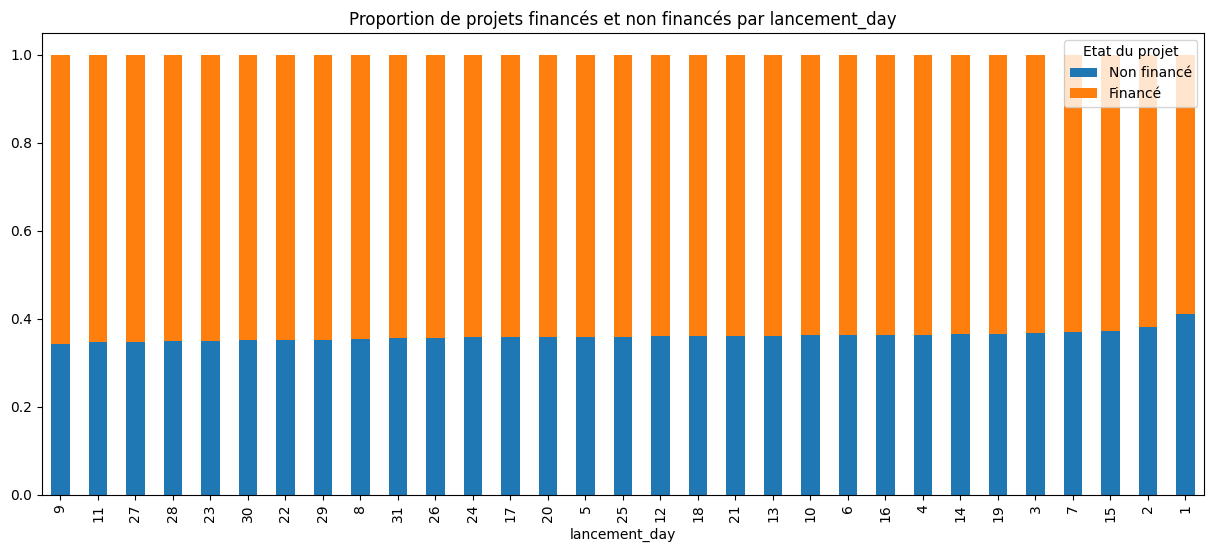

Max : 0.38 - Min : 0.33 - Etendue : 0.05


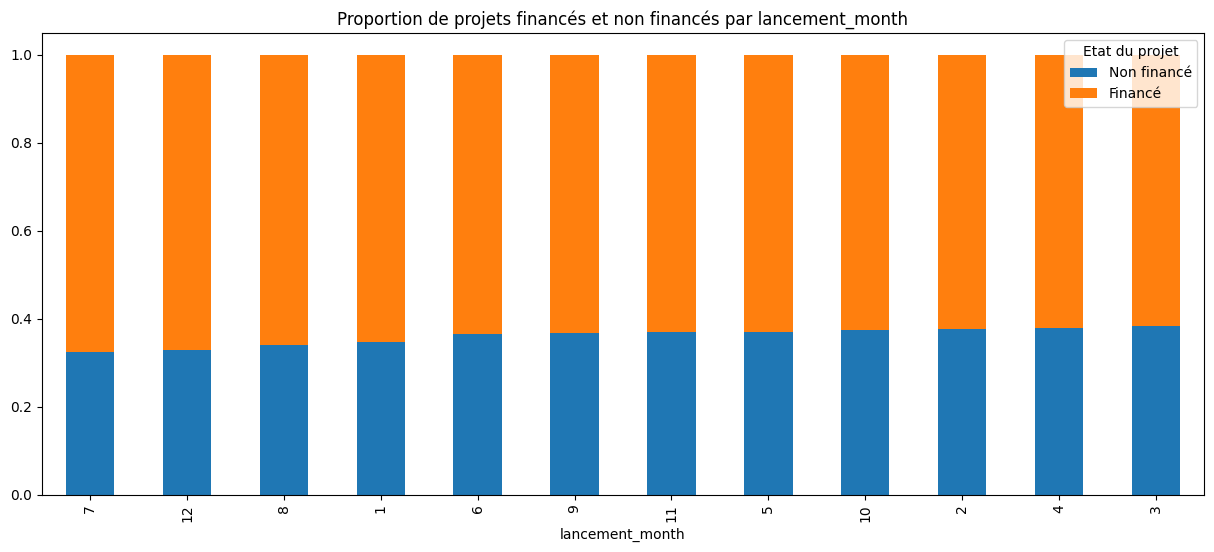

Max : nan - Min : nan - Etendue : nan


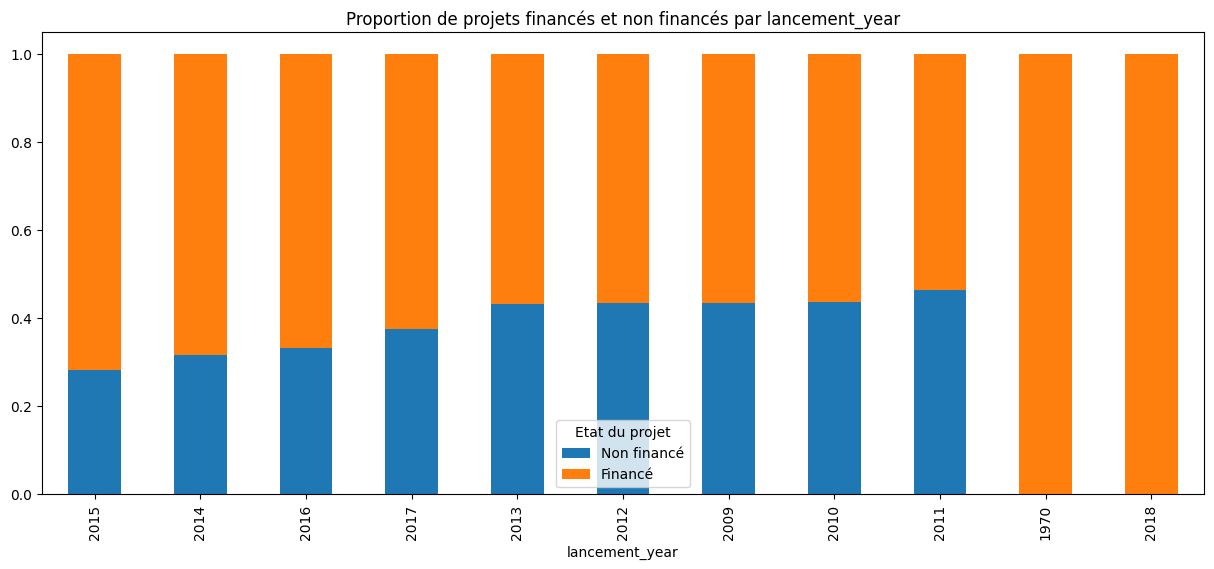

Max : 0.37 - Min : 0.34 - Etendue : 0.03


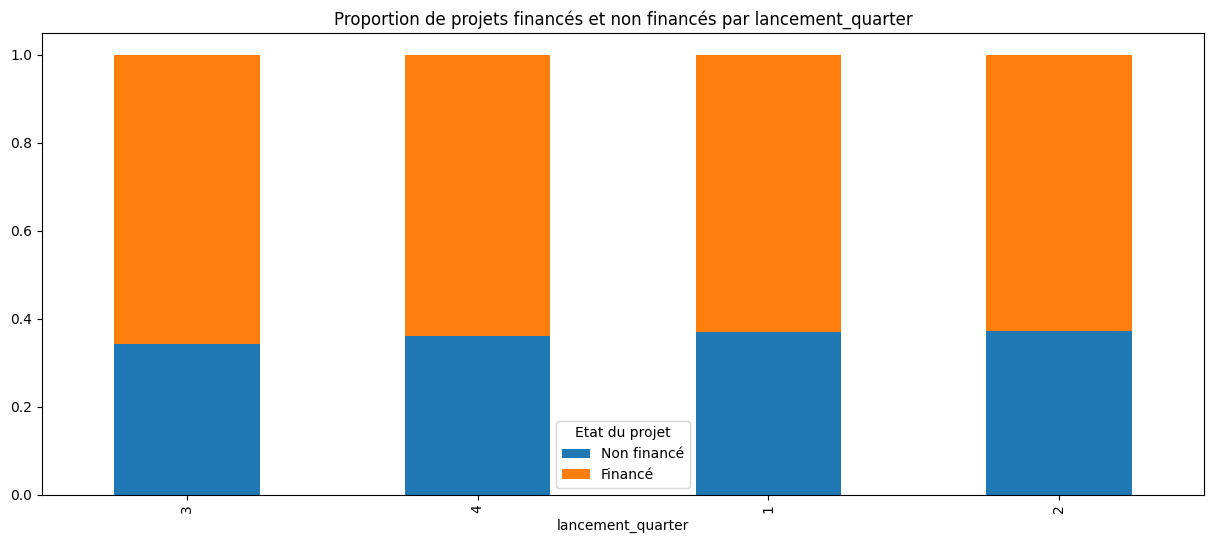

Max : 0.4 - Min : 0.34 - Etendue : 0.06


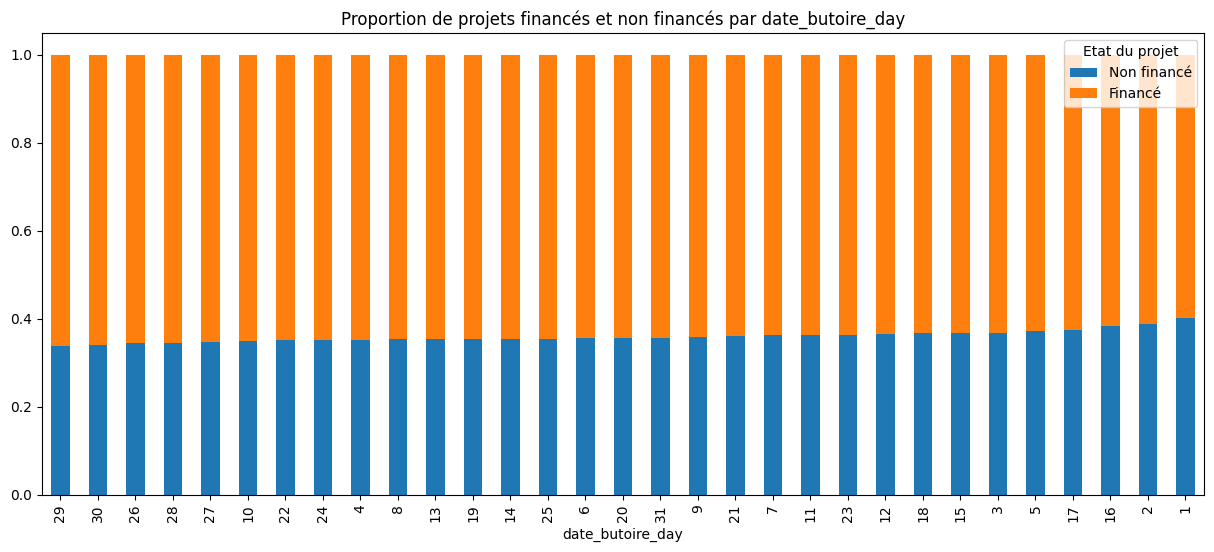

Max : 0.38 - Min : 0.33 - Etendue : 0.05


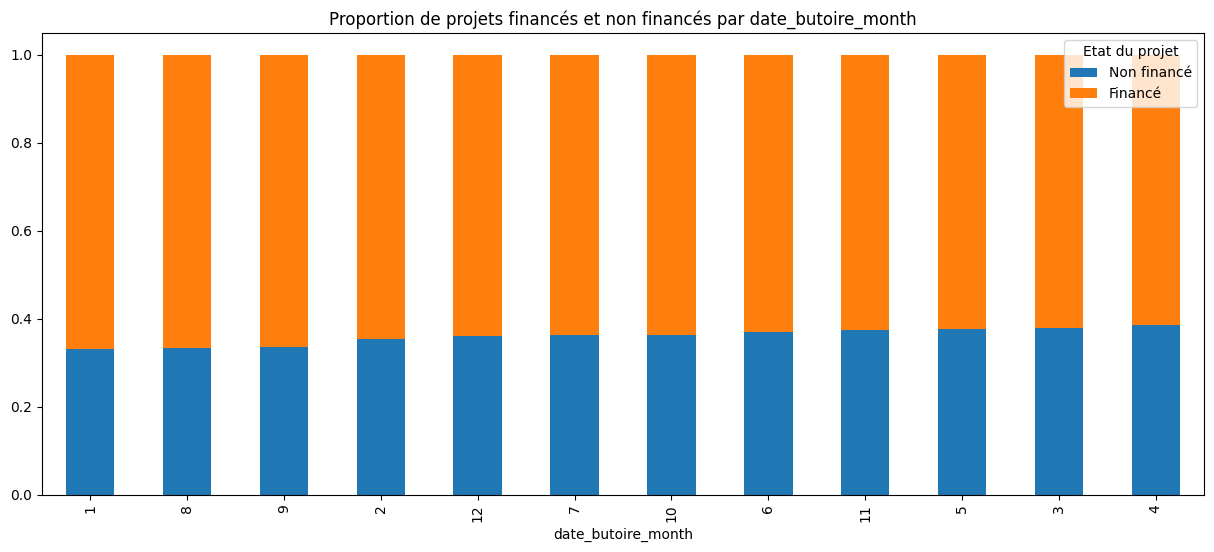

Max : 0.47 - Min : 0.19 - Etendue : 0.28


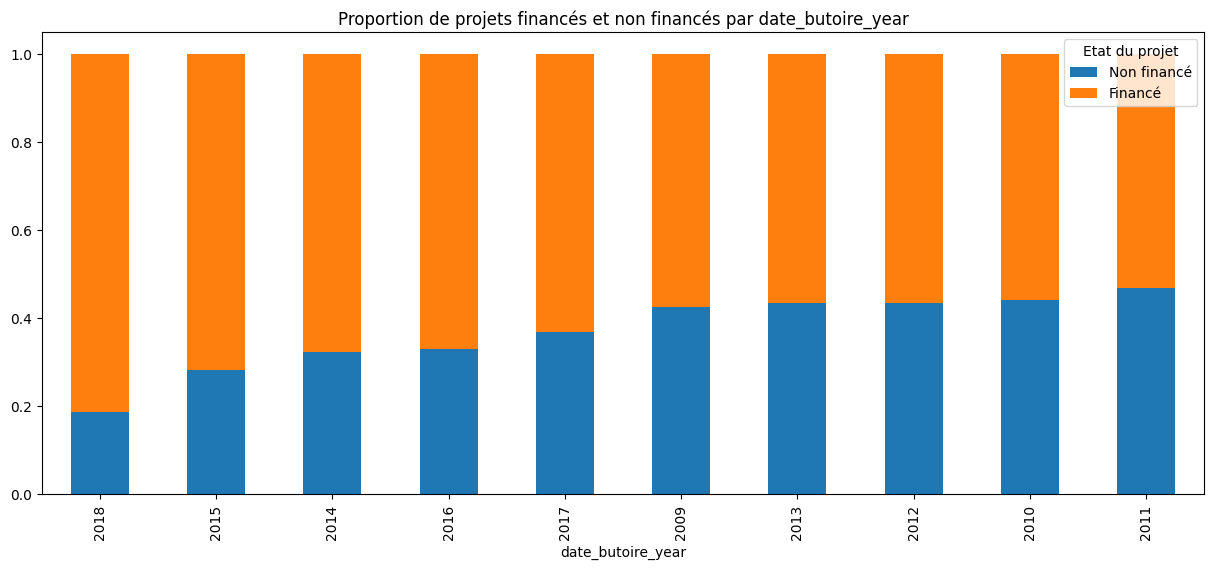

Max : 0.38 - Min : 0.34 - Etendue : 0.04


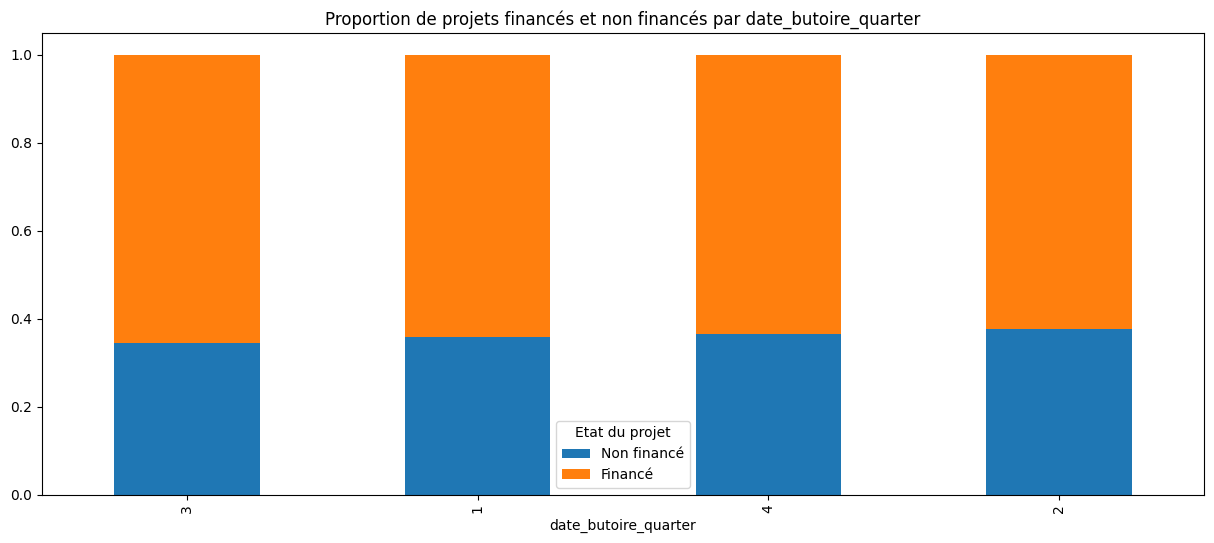

In [ ]:
for col in ['lancement_day', 'lancement_month', 'lancement_year', 'lancement_quarter', 'date_butoire_day', 'date_butoire_month', 'date_butoire_year', 'date_butoire_quarter']:
    plot_etat_proportion(financement_df, col, "etat_int")

On ne remarque pas de tendances particulières... Essayons d'ajouter une colonne ecart_temps, qui calcul le temps entre la date de lancement et la date butoire.

In [ ]:
financement_df['ecart_jours'] = (financement_df['date_butoire'] - financement_df['lancement']).dt.days

Max : 0.58 - Min : 0.19 - Etendue : 0.39


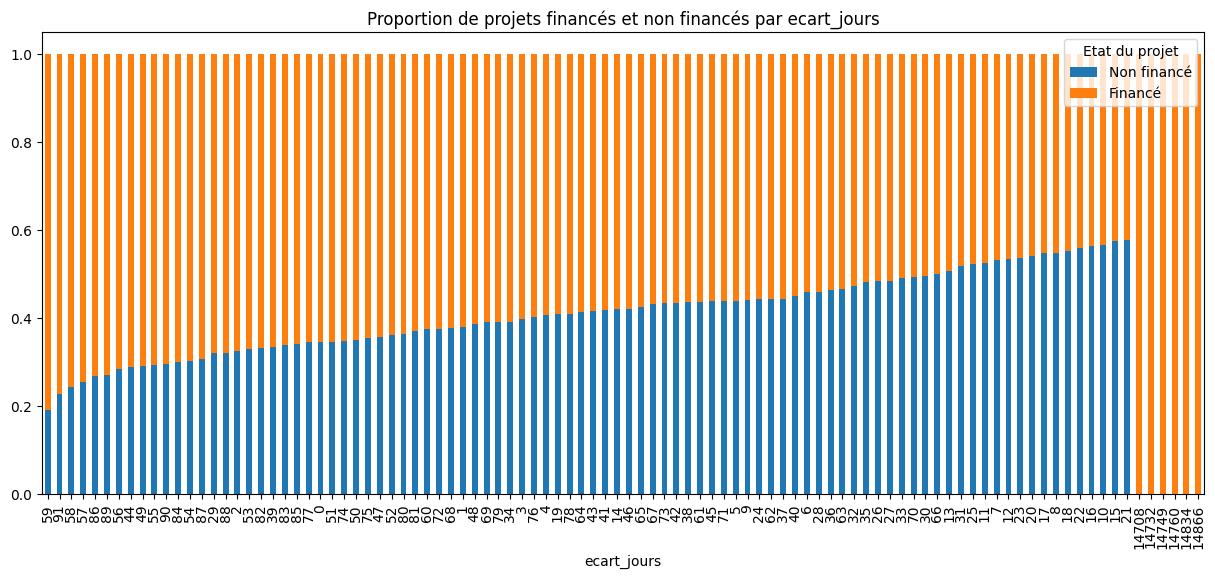

In [ ]:
plot_etat_proportion(financement_df, "ecart_jours", "etat_int")

On constate que plus le temps de financement est long (ecart_jours élevé), plus le projet a de chance d'être financé. 

On peut aussi observer que nous avons des valeurs abérentes (14 708 jours et + soit + de 40 ans). Regardons ces données de plus près

In [ ]:
financement_df[financement_df["ecart_jours"] > 14000][["date_butoire", "lancement"]]

,date_butoire,lancement
2842,2010-09-15,1970-01-01 01:00:00
48147,2010-08-14,1970-01-01 01:00:00
75397,2010-05-21,1970-01-01 01:00:00
94579,2010-06-01,1970-01-01 01:00:00
247913,2010-05-04,1970-01-01 01:00:00
273779,2010-04-10,1970-01-01 01:00:00


On remarque que la date de lancement semble être une valeur par défault, vu que nous avons très peu de ligne avec cette valeur, nous décidons de les supprimer

In [ ]:
financement_df = financement_df[financement_df["ecart_jours"] < 14000]

Max : 0.38 - Min : 0.23 - Etendue : 0.15


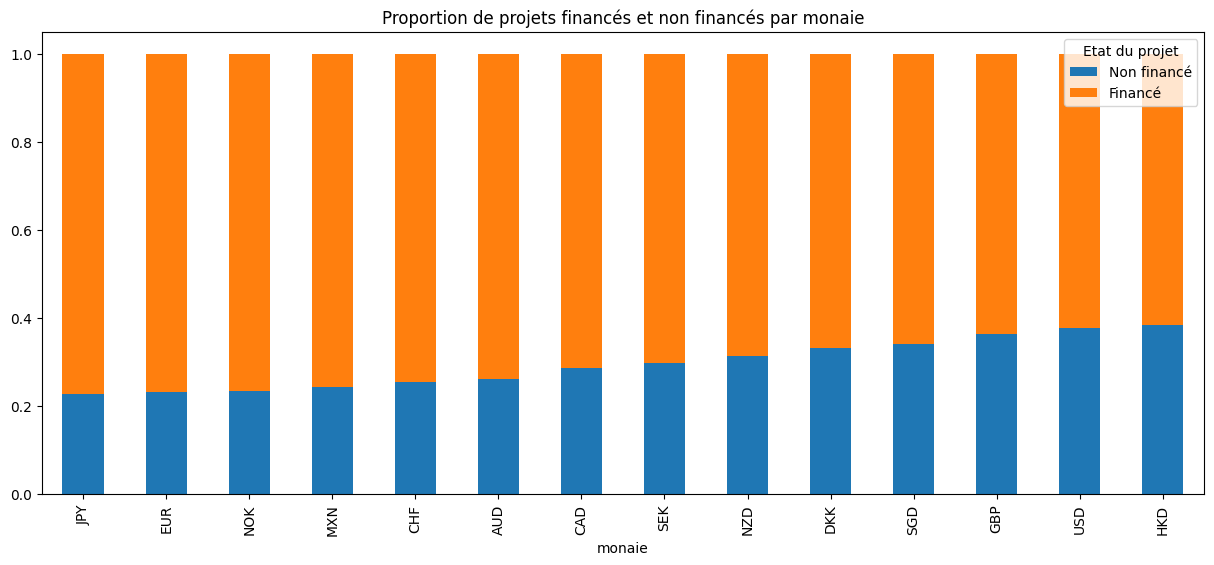

In [ ]:
plot_etat_proportion(financement_df, "monaie", "etat_int")

On remarque une légère différence en fonction de la monnaie (Etendue du taux de projet financé : 15%). Dummifions cette colonnes et nous vériferons la corrélation avec la variable_int.

Passons désormais à la dernière variable : pays

In [ ]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["monaie"])], axis=1)

Max : 0.38 - Min : 0.16 - Etendue : 0.22


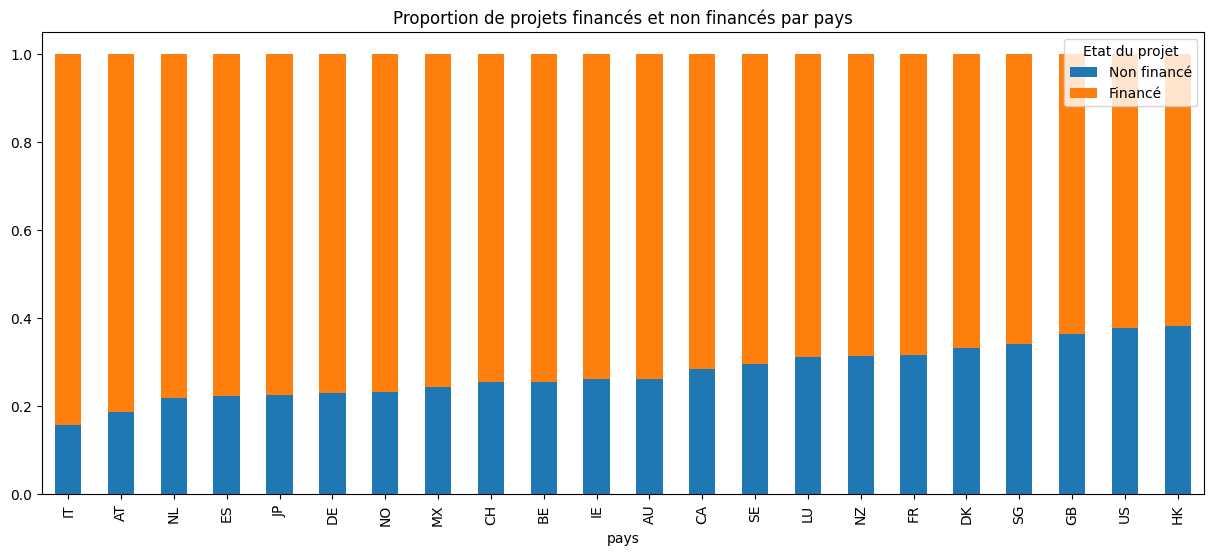

In [ ]:
plot_etat_proportion(financement_df, "pays", "etat_int")

Là aussi on remarque une différence entre les pays (Etendue du taux de projet financé : 22%), nous allons aussi les dummifier. 

Vérifions si nous obtenons des écarts plus important en fonction du continent.

In [ ]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["pays"])], axis=1)

In [ ]:
def get_continent(iso_code):
  """
  Fonction pour récupérer le continent à partir du code ISO du pays.

  Paramètres :
  - iso_code (str) : le code ISO à deux lettres du pays.

  Retourne :
  - str : le code du continent (AF, AS, EU, NA, OC, SA, AN) si le code ISO du pays est reconnu, "Inconnue" sinon.
  """

  try:
      return pc.country_alpha2_to_continent_code(iso_code)
  except:
      return "Inconnue"

  
# On ajoute une colonne continent en utilisant la fonction get_continent pour récupérer le continent à partir du code ISO du pays
financement_df['continent'] = financement_df['pays'].apply(get_continent)

Max : 0.37 - Min : 0.27 - Etendue : 0.1


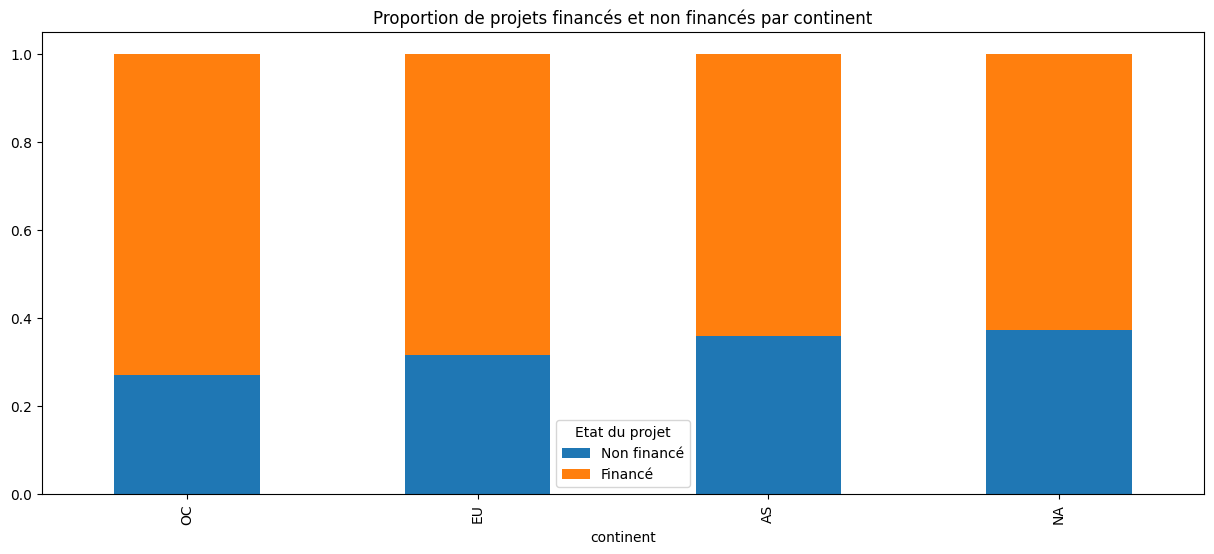

In [ ]:
plot_etat_proportion(financement_df, "continent", "etat_int")

On peut en conclure que peut importe le continent, le taux de projet financé est similaire

In [ ]:
corr_matrix = financement_df.corr()

In [ ]:
corr_matrix["etat_int"].abs().sort_values(ascending=False).head(15)

etat_int                         1.000000
supporters_cat_Elevé             0.562952
promesse_usd2_cat_Elevé          0.538915
supporters_cat_Très faible       0.310833
promesse_usd2_cat_Faible         0.304607
supporters_cat_Faible            0.280775
promesse_usd2_cat_Très faible    0.260868
supporters_cat_Moyen             0.199074
objectif_usd_cat_Elevé           0.194565
promesse_usd2_cat_Moyen          0.194300
objectif_usd_cat_Très faible     0.153932
supporters                       0.129199
ecart_jours                      0.118437
promesse_usd2                    0.111092
categorie_principale_Music       0.105305
Name: etat_int, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Importer les modèles ici
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
X_columns = corr_matrix["etat_int"].abs().sort_values(ascending=False).head(15).reset_index()["index"].to_list()[1:]

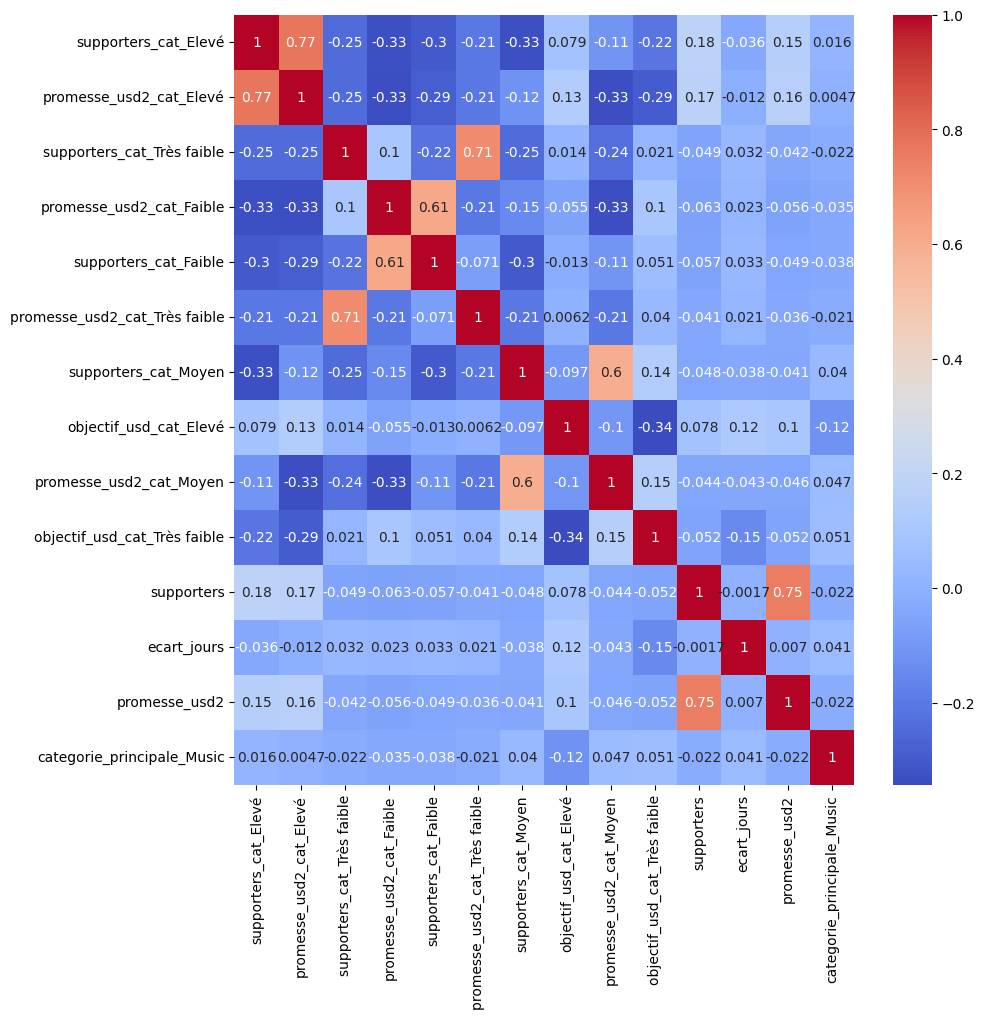

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(financement_df[X_columns].corr(), annot=True, cmap="coolwarm", ax=ax)
plt.show()

In [ ]:
# On sépare les features et la variable cible en deux DataFrames X et y
X = financement_df[X_columns]
y = financement_df['etat_int']

# On utilise la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# On utilise StandardScaler pour centrer et réduire les données d'entraînement, puis appliquer la même transformation aux données de test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# On crée un modèle de régression logistique et on l'entraîne sur les données d'entraînement normalisées
model = LogisticRegression() # Ici j'utilise une LogisticRegression, à vous de tester d'autres modèles (pensez à importer le modèle plus haut !)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # On utilise le modèle pour prédire la variable cible y_test à partir des features X_test

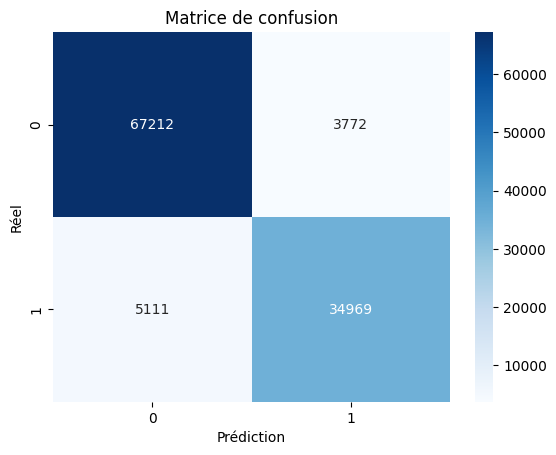

In [ ]:
# On calcule la matrice de confusion pour évaluer les performances du modèle
conf_matrix = confusion_matrix(y_test, y_pred)

# On affiche la matrice de confusion sous forme de heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

In [ ]:
class_report = classification_report(y_test, y_pred) # On affiche le classification report pour avoir un aperçu détaillé des performances du modèle par classe.
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     70984
           1       0.90      0.87      0.89     40080

    accuracy                           0.92    111064
   macro avg       0.92      0.91      0.91    111064
weighted avg       0.92      0.92      0.92    111064



In [ ]:
# Récupére les coefficients et les noms de variables
coefs = model.coef_[0]
variable_names = X_columns

# Créé un DataFrame pour stocker les coefficients et les noms de variables
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefs})

# Trie les coefficients par ordre décroissant de valeur absolue
coefficients_df['AbsoluteCoefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values('AbsoluteCoefficient', ascending=False).drop('AbsoluteCoefficient', axis=1)

print(coefficients_df)

                         Variable  Coefficient
12                  promesse_usd2     5.844101
1         promesse_usd2_cat_Elevé     3.378145
0            supporters_cat_Elevé     2.941221
8         promesse_usd2_cat_Moyen     2.453686
6            supporters_cat_Moyen     2.432820
9    objectif_usd_cat_Très faible     1.784961
7          objectif_usd_cat_Elevé    -1.753341
4           supporters_cat_Faible     1.585211
3        promesse_usd2_cat_Faible     1.306520
2      supporters_cat_Très faible     0.871491
10                     supporters     0.741512
5   promesse_usd2_cat_Très faible     0.612382
13     categorie_principale_Music     0.256166
11                    ecart_jours    -0.244513
